In [4]:
pip install astropy matplotlib numpy rawpy imageio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 2.3 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
import zipfile
import os
import glob
import rawpy
import numpy as np
import shutil
import matplotlib.pyplot as plt
from skimage.transform import resize
import gc

In [ ]:
# Define base directory where ZIP files are located
# base_dir = "data"
base_dir = "/content/drive/MyDrive/Image Stacking/data"

# List of ZIP files and their target extracted folders
files = {
    "Bias": "Bias 37F ISO 800",
    "Darks": "Darks 44F ISO 800 8min",
    "M31": "M31 RAW 48F ISO800 8min",
}

In [1]:
for category, folder_name in files.items():
    zip_path = os.path.join(base_dir, f"{folder_name}.zip")
    extract_folder = os.path.join(base_dir, folder_name)

    # Ensure the target extraction folder exists
    os.makedirs(extract_folder, exist_ok=True)

    # Extract files
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        temp_extract_path = os.path.join(base_dir, f"{folder_name}_temp")
        os.makedirs(temp_extract_path, exist_ok=True)
        zip_ref.extractall(temp_extract_path)

        # Move files from temp folder to main folder, avoiding nested directories
        for root, _, filenames in os.walk(temp_extract_path):
            for file in filenames:
                src_file = os.path.join(root, file)
                dest_file = os.path.join(extract_folder, file)
                shutil.move(src_file, dest_file)

        # Remove temporary extraction folder
        shutil.rmtree(temp_extract_path)

    print(f"Extracted {category} files to {extract_folder}")

Extracted Bias files to data/Bias 37F ISO 800
Extracted Darks files to data/Darks 44F ISO 800 8min
Extracted M31 files to data/M31 RAW 48F ISO800 8min


Found Bias image: data/Bias 37F ISO 800/IMG_0806.CR2
Found Darks image: data/Darks 44F ISO 800 8min/IMG_0819.CR2
Found M31 image: data/M31 RAW 48F ISO800 8min/IMG_0705.CR2


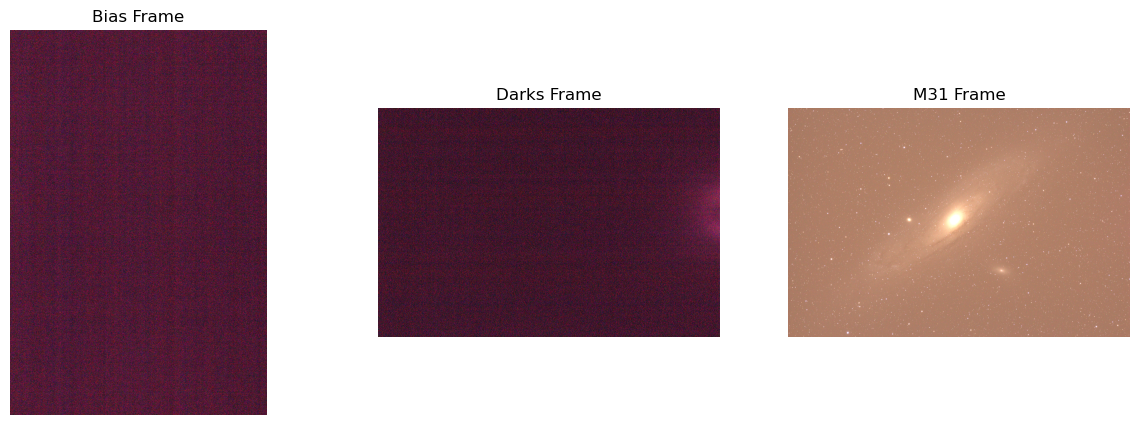

In [2]:
# Function to find the first CR2 file in a directory
def find_cr2_file(directory):
    cr2_files = glob.glob(os.path.join(directory, "*.CR2"))  # No recursion needed
    return cr2_files[0] if cr2_files else None

# Load and display one image from each category
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (category, folder_name) in enumerate(files.items()):
    folder_path = os.path.join(base_dir, folder_name)
    cr2_file = find_cr2_file(folder_path)

    if cr2_file:
        print(f"Found {category} image: {cr2_file}")
        with rawpy.imread(cr2_file) as raw:
            rgb_image = raw.postprocess()  # Convert to RGB

        # Normalize image for display
        rgb_image = rgb_image / 255.0  # Scale pixel values to [0,1]

        # Display image
        axes[i].imshow(rgb_image)
        axes[i].set_title(f"{category} Frame")
        axes[i].axis("off")
    else:
        print(f"No CR2 files found in {folder_path}")

plt.show()

In [4]:
# Function to load CR2 images in full-color mode and resize them efficiently
def load_and_resize_cr2_images(folder, target_shape=None, max_images=None):
    cr2_files = glob.glob(os.path.join(folder, "*.CR2"))

    if max_images:
        cr2_files = cr2_files[:max_images]  # Load only a subset to reduce RAM usage

    images = []
    for file in cr2_files:
        with rawpy.imread(file) as raw:
            img = raw.postprocess(
                use_camera_wb=True,       # Apply camera's white balance
                no_auto_bright=True,      # Prevent auto brightening (keeps linear response)
                output_bps=16,            # Use 16-bit output for full color depth
                demosaic_algorithm=rawpy.DemosaicAlgorithm.AHD,  # Use high-quality demosaicing
                gamma=(1, 1),             # Keep linear gamma
                half_size=False           # Ensure full resolution color processing
            )
            
            if target_shape:
                img_resized = resize(img, target_shape, anti_aliasing=True)  # Resize to consistent shape
            else:
                img_resized = img  # Keep original size if target shape is not defined
            
            images.append(img_resized)

        del raw  # Free memory after processing each file

    # Ensure all images have the same shape
    min_shape = images[0].shape if images else None

    # Convert to NumPy array & store as float32 (saves RAM)
    images = np.array([resize(img, min_shape, anti_aliasing=True) for img in images], dtype=np.float32)
    
    return images, min_shape

In [ ]:
target_resolution = None #(1024, 1024)
max_images = None

# Load Bias, Dark, and Light Frames in Color Mode with Efficient Memory Usage
bias_frames, _ = load_and_resize_cr2_images(os.path.join(base_dir, files["Bias"]), target_resolution, max_images)
dark_frames, _ = load_and_resize_cr2_images(os.path.join(base_dir, files["Darks"]), target_resolution, max_images)
light_frames, _ = load_and_resize_cr2_images(os.path.join(base_dir, files["M31"]), target_resolution, max_images)

# Ensure no empty datasets before proceeding
if bias_frames is None or dark_frames is None or light_frames is None:
    raise FileNotFoundError("Error: One or more datasets are missing. Check your file paths!")

# Create Master Bias (Median in RGB Space)
master_bias = np.median(bias_frames, axis=0)

# Create Master Dark (Subtract Bias, then Median in RGB Space)
master_dark = np.median(dark_frames - master_bias, axis=0)

# Apply Calibration to Light Frames in Color Space
calibrated_lights = [(light - master_dark) for light in light_frames]

# Free Memory After Processing
del bias_frames, dark_frames
gc.collect()  # Force garbage collection to free RAM

# Function to Normalize Images for Display
def normalize_image(img):
    img = img - np.min(img)
    img = img / np.max(img)  # Normalize to [0,1]
    return np.clip(img, 0, 1)  # Ensure values stay in valid range

# Display Master Frames in Full Color
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(normalize_image(master_bias))
axes[0].set_title("Master Bias")

axes[1].imshow(normalize_image(master_dark))
axes[1].set_title("Master Dark")

axes[2].imshow(normalize_image(calibrated_lights[0]))
axes[2].set_title("Sample Calibrated Light")

plt.show()

In [ ]:
print(calibrated_lights[0])
print(np.shape(calibrated_lights[0]))

In [ ]:
import os
import imageio.v2 as imageio

output_dir = os.path.join(base_dir, "Processed_Images")
os.makedirs(output_dir, exist_ok=True)

for i, calibrated_light in enumerate(calibrated_lights):
    light_path = os.path.join(output_dir, f"Calibrated_Light_{i+1}.tiff")
    
    imageio.imwrite(light_path, (normalize_image(calibrated_light) * 65535).astype(np.uint16))


In [ ]:
preprocessing_text = """
# Exhaustive List of Data Preprocessing Techniques for Astrophotography

## **Basic Preprocessing**
**RAW Conversion** – Convert `.CR2` to linear data using `rawpy`.  
**Demosaicing** – Convert Bayer pattern to full-color image.  
**Bit Depth Conversion** – Convert from **12/14-bit** to **16-bit** for full dynamic range.  
**Resize & Rescale** – Ensure uniform image dimensions for stacking.  
**Orientation Correction** – Apply correct **rotation & flipping** based on metadata.  

## **Noise & Sensor Artifact Removal**
**Bias Frame Subtraction** – Removes readout noise from the camera sensor.  
**Dark Frame Subtraction** – Removes thermal noise from long exposures.  
**Flat Frame Correction** – Removes vignetting, dust spots, and uneven illumination.  
**Dark Flat Frames** *(Optional)* – If flat frames have thermal noise, use a master dark flat frame.  
**Defective Pixel Correction** – Removes hot pixels (use median filtering or dithering).  
**Cosmic Ray Removal** – Filters out high-energy particles using sigma-clipping.  

## **Image Registration (Alignment)**
**Translation Correction** – Fix slight shifts in image position.  
**Rotation & Skew Correction** – Align rotated frames using feature-matching.  
**Distortion Correction** – Account for lens/telescope warping.  
**Sub-Pixel Alignment** – Uses advanced interpolation to improve sharpness.  

## **Background Correction & Normalization**
**Gradient Removal** – Fix uneven sky background using polynomial fitting.  
**Sky Background Subtraction** – Removes light pollution and sky glow.  
**Histogram Equalization** – Normalizes brightness across images.  
**Adaptive Background Correction** – Dynamically adjusts dark regions to balance illumination.  

## **Image Cleaning & Enhancement**
**Hot Pixel Removal** – Eliminates bright stuck pixels (median filtering).  
**Cold Pixel Removal** – Corrects abnormally dark pixels.  
**Gaussian Blur Noise Reduction** – Blurs noise without affecting stars.  
**Wavelet Denoising** – Removes noise while preserving fine details.  
**Adaptive Noise Reduction** – Suppresses noise in darker regions but keeps details in bright ones.  

## **Advanced Preprocessing (Optional)**
**Flat Field Correction with Synthetic Flats** – If no flat frames are available, estimate vignetting correction.  
**Fringe Removal** – If using infrared or long exposures, removes color fringes around stars.  
**Bad Frame Rejection** – Identify and remove frames with tracking errors, clouds, or sensor artifacts.  
**Deconvolution** – Enhances sharpness by reversing the effects of atmospheric distortion.  
**Dynamic Range Compression** – Adjusts pixel intensities to retain details in both bright and dark areas.  

## **Summary: When to Use These Techniques**
| Technique | Required? | When to Use? |
|-----------|-----------|--------------|
| **Bias Subtraction** | Always | Removes sensor readout noise |
| **Dark Subtraction** | Always | Removes thermal noise |
| **Flat Frame Correction** | Always | Fixes vignetting & dust spots |
| **Image Registration** | Always | Aligns all images for stacking |
| **Gradient Removal** | Sometimes | If sky background is uneven |
| **Noise Reduction** | Sometimes | If stacking doesn't fully remove noise |
| **Hot Pixel Removal** | Sometimes | If camera has hot pixels |
| **Bad Frame Rejection** | Sometimes | If some images have tracking issues |
| **Wavelet Denoising** | Sometimes | If final stacked image is noisy |
| **Deconvolution** | Optional | For sharpening after stacking |

---"""

from IPython.display import display, Markdown
display(Markdown(preprocessing_text))
